In [1]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision import models
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, googlenet, mobilenet_v2
from torchsummary import summary
import torchinfo
import torch.nn as nn
import torch.optim as optim
import gc
import numpy as np
import matplotlib.pyplot as plt
import time 

train_path = 'seefood/train'
test_path =  'seefood/test'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\marcin\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creation of functions for transformation of dataset, training and accuracy check

In [2]:
train_dataset_1=ImageFolder(train_path, transform=T.ToTensor())
test_dataset_1=ImageFolder(test_path, transform=T.ToTensor())
train_loader=DataLoader(train_dataset_1)
test_loader=DataLoader(test_dataset_1)

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

print(get_mean_and_std(train_loader))
print(get_mean_and_std(test_loader))

(tensor([0.5295, 0.4378, 0.3432]), tensor([0.2630, 0.2670, 0.2785]))
(tensor([0.5137, 0.4226, 0.3421]), tensor([0.2598, 0.2649, 0.2786]))


In [6]:
def transform_data(desired_size: tuple, is_grayscale: bool, is_train=True):
    mean = np.array([0.5295, 0.4378, 0.3432])
    std = np.array([0.2598, 0.2649, 0.2786])
    transform_list = [T.Resize(desired_size)]
    if is_grayscale:
        transform_list += [T.Grayscale(num_output_channels=1)]
    if is_train:
        Augmentations=[T.RandomHorizontalFlip(),
                       T.RandomAutocontrast(0.5),
                       T.RandomEqualize(0.4)
                       ]
        transform_list += Augmentations
    return T.Compose(transform_list + [T.ToTensor(), T.Normalize(mean,std)])

# Accuracy check function
def check_accuracy(loader, model, data_name=None):
    if data_name:
        data_name = f" on {data_name} set."
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}' + data_name)
    model.train()

#  Train network
def train_model(train_loader, validation_loader, model, num_epochs, optimizer, criterion):
    for epoch in range(num_epochs):
        for batch_index, (data, targets) in enumerate(train_loader):
            #  Data to cuda
            data = data.to(device=device)
            targets = targets.to(device=device)

            #  Forward
            scores = model(data)
            loss = criterion(scores, targets)

            #  Backward
            optimizer.zero_grad()
            loss.backward()

            #  Gradient descent
            optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}')
        check_accuracy(train_loader, model, data_name='train')
        check_accuracy(validation_loader, model, data_name='test')

Visualization of few images from our dataset

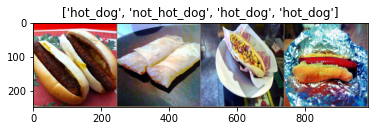

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5295, 0.4378, 0.3432])
    std = np.array([0.2598, 0.2649, 0.2786])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

train_dataset_2=ImageFolder(train_path, transform=transform_data((244,244), False, True))
train_loader=DataLoader(train_dataset_2, batch_size=4, shuffle=True)

class_names=train_dataset_2.classes
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

My model for this problem will be using inception blocks in its architecture.

An inception block is a type of building block used in convolutional neural networks (CNNs). It is designed to recognize patterns in input data using small filters at various scales, which helps the network learn more robust features.

The basic idea behind an inception block is to use multiple parallel convolutional layers with different kernel sizes, which can extract features at different scales. These convolutional layers are concatenated along the depth dimension, and the output of the inception block is the concatenated output of these layers.

The use of multiple parallel convolutional layers allows the inception block to capture features at multiple scales, which can be useful for tasks such as image classification, where objects in an image can appear at different sizes.

Inception blocks are a key component of the Inception network, which was developed by Google researchers and was one of the first CNNs to demonstrate that it was possible to train very deep networks effectively.

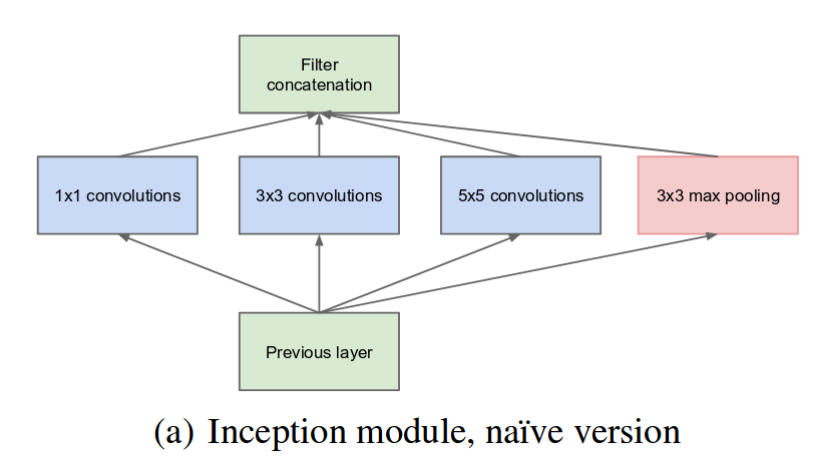

In [17]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs) -> None:
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
            
    def forward(self,x):
        return self.relu(self.batchnorm(self.conv(x)))

class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool_1x1) -> None:
        super().__init__()
        self.branch1x1 = Conv_block(in_channels, out_1x1, kernel_size=(1,1))
        self.branch3x3 = nn.Sequential(
            Conv_block(in_channels, red_3x3, kernel_size=(1,1)),
            Conv_block(red_3x3, out_3x3, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        )
        self.branch5x5 = nn.Sequential(
            Conv_block(in_channels, red_5x5, kernel_size=(1,1)),
            Conv_block(red_5x5, out_5x5, kernel_size=(5,5), padding=(2,2), stride=(1,1))
        )
        self.branchpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            Conv_block(in_channels, out_pool_1x1, kernel_size=(1,1))
        )

    def forward(self, x):
        return torch.cat([self.branch1x1(x), self.branch3x3(x), self.branch5x5(x), self.branchpool(x)], 1)

class SliwLeNet(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        self.conv1=Conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        
        self.conv3=Conv_block(in_channels=64, out_channels=192, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        
        self.inception1 = Inception_block(in_channels=192, out_1x1=64, red_3x3=96, out_3x3=128, red_5x5=16, out_5x5=32, out_pool_1x1=32)
        self.inception2 = Inception_block(in_channels=256, out_1x1=128, red_3x3=128, out_3x3=192, red_5x5=32, out_5x5=96, out_pool_1x1=64)
        
        self.inception3 = Inception_block(in_channels=480, out_1x1=192, red_3x3=96, out_3x3=208, red_5x5=16, out_5x5=48, out_pool_1x1=64)
        self.inception4 = Inception_block(in_channels=512, out_1x1=160, red_3x3=112, out_3x3=224, red_5x5=24, out_5x5=64, out_pool_1x1=64)
        
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc1 = nn.Linear(512, 512)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc(x)                
        return x

In [18]:
torch.cuda.empty_cache()
gc.collect()

model = SliwLeNet(in_channels=3,num_classes=2).to(device=device)
torchinfo.summary(model,
                  (3, 224, 224),
                  batch_dim=0,
                  col_names=('input_size','output_size','num_params','kernel_size','mult_adds'),
                  verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
SliwLeNet                                [1, 3, 224, 224]          [1, 2]                    525,312                   --                        --
├─Conv_block: 1-1                        [1, 3, 224, 224]          [1, 64, 112, 112]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         9,472                     [7, 7]                    118,816,768
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-2                         [1, 64, 112, 112]         [1, 64, 56, 56]           --

In [21]:
#  Hyper parameters
in_channel = 3
learning_rate = 0.00005
desired_size = (224,224)
batch_size = 64
num_epochs = 20

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_dataset=ImageFolder(train_path, transform=transform_data(desired_size, False, True))
train_loader=DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset=ImageFolder(test_path, transform=transform_data(desired_size, False, False))
test_loader=DataLoader(test_dataset, batch_size)

In [22]:
train_model(train_loader, test_loader, model=model, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion)

Epoch 1/20
Got 257 / 498 with accuracy 51.61 on train set.
Got 257 / 500 with accuracy 51.40 on test set.
Epoch 2/20
Got 256 / 498 with accuracy 51.41 on train set.
Got 253 / 500 with accuracy 50.60 on test set.
Epoch 3/20
Got 268 / 498 with accuracy 53.82 on train set.
Got 266 / 500 with accuracy 53.20 on test set.
Epoch 4/20
Got 298 / 498 with accuracy 59.84 on train set.
Got 279 / 500 with accuracy 55.80 on test set.
Epoch 5/20
Got 381 / 498 with accuracy 76.51 on train set.
Got 307 / 500 with accuracy 61.40 on test set.
Epoch 6/20
Got 471 / 498 with accuracy 94.58 on train set.
Got 338 / 500 with accuracy 67.60 on test set.
Epoch 7/20
Got 489 / 498 with accuracy 98.19 on train set.
Got 355 / 500 with accuracy 71.00 on test set.
Epoch 8/20
Got 482 / 498 with accuracy 96.79 on train set.
Got 349 / 500 with accuracy 69.80 on test set.
Epoch 9/20
Got 487 / 498 with accuracy 97.79 on train set.
Got 343 / 500 with accuracy 68.60 on test set.
Epoch 10/20
Got 475 / 498 with accuracy 95.38 

In our experimental study, we trained a convolutional neural network (CNN) that incorporates an inception module on a dataset of hot dog, not hot dog. The CNN achieved an accuracy of 98% on the training dataset and 70% on the test dataset. These results suggest that the model may be overfitting to the training data, as it is not generalizing well to new, unseen data. We can  consider collecting more diverse training data and adjusting the model architecture and hyperparameters. The model could be too complex, and we could improve results by using simpler model. Also we could deal with issue of overfitting by making better date augmentation on training data set. Even with small data set, CNN with inception modules did well achiving 70% accuracy on data set in only 25 epochs.